# Imports

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow import keras

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels as sm
from statsmodels.tsa.arima_model import ARIMA

from fbprophet import Prophet

import warnings

C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\s

In [3]:
btc = pd.read_csv('../data/btc.csv')
btc.set_index('Date', inplace=True)

# Forecasting Models

In this section we use Faebook's Prophet and ARIMA to do future forecasting of Bitcoin prices. We also attempt to use LSTM to do a price prediction and see how well it does.

## Facebook Prophet

Facebook Prophet requires that the dates of your time series are located in a column titled `ds` and the values of the series in a column titled `y`. We create two dataframes below for linear and logarithmic `Close`.

In [4]:
df_prophet = btc.reset_index()
df_prophet = df_prophet[['Date', 'Close']]
df_prophet.columns = ['ds', 'y']

df_prophet_log = btc.reset_index()
df_prophet_log = df_prophet_log[['Date', 'LogClose']]
df_prophet_log.columns = ['ds', 'y']

Instantiate, fit, predict and plot

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


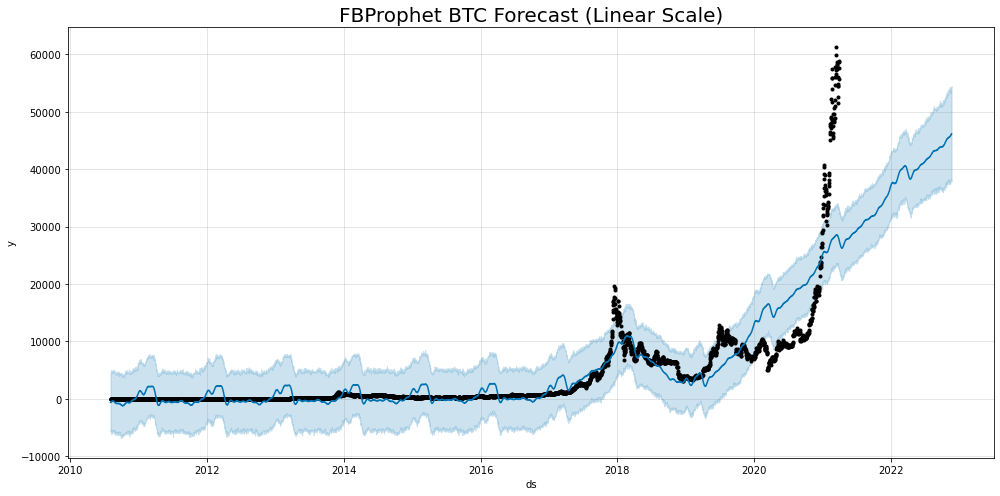

In [11]:
prophet = Prophet()
prophet.fit(df_prophet)

future = prophet.make_future_dataframe(periods=600)
forecast = prophet.predict(future)

fig = prophet.plot(forecast, figsize=(14,7))
plt.title('FBProphet BTC Forecast (Linear Scale)', size=20)
plt.tight_layout()
plt.savefig('../images/prophet1.png', transparent=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


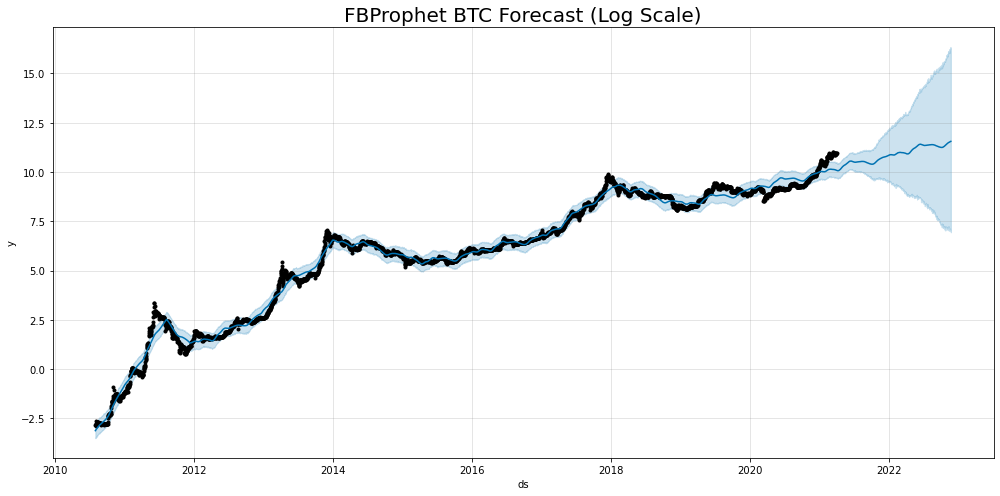

In [12]:
prophet2 = Prophet()
prophet2.fit(df_prophet_log)

future2 = prophet2.make_future_dataframe(periods=600)
forecast2 = prophet2.predict(future)

fig2 = prophet2.plot(forecast2, figsize=(14,7))
plt.title('FBProphet BTC Forecast (Log Scale)', size=20)
plt.tight_layout()
plt.savefig('../images/prophet2.png', transparent=True)

Note that above Prophet plots aren't tuned at all, and are purely relying on past `Close` prices to make a future prediction. It's interesting to note that Prophet did not predict the recent growth in Bitcoin price in recent months, but it projects an incremental forecast into the future. Prophet is also less clear on the logarithmic scale as you can observe the upper and lower bounds increase drastically after about a year in of forecast.

## ARIMA

Next, we will attempt to use ARIMA to forecast Bitcoin price. In order to use ARIMA model, we need to make sure that our data is stationary. Earlier in EDA section we had featured a differenced `Close` column in order to fulfil this criteria. Let's take a look at the plot again.

Text(0.5, 1.0, 'First-Order Differenced Close Price')

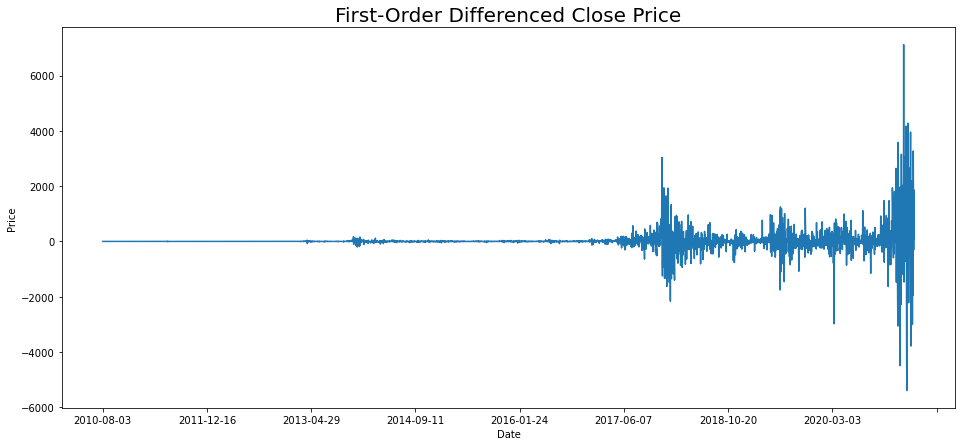

In [3]:
df_arima = btc[['Close', 'Close_Diff1', 'Year']]

df_arima['Close_Diff1'].plot(figsize=(16,7))
plt.ylabel('Price')
plt.title("First-Order Differenced Close Price", size=20)


We want a shorter timeframe for ARIMA forecasting as we see quite a big variation in the dataset in times of the differenced `Close`. We'll select data from 2020 onwards.

In [4]:
df_arima = df_arima[df_arima['Year'] > 2019]

Let's take a look at the auto-correlation (ACF) plots on `Close` and `Close_Diff`.

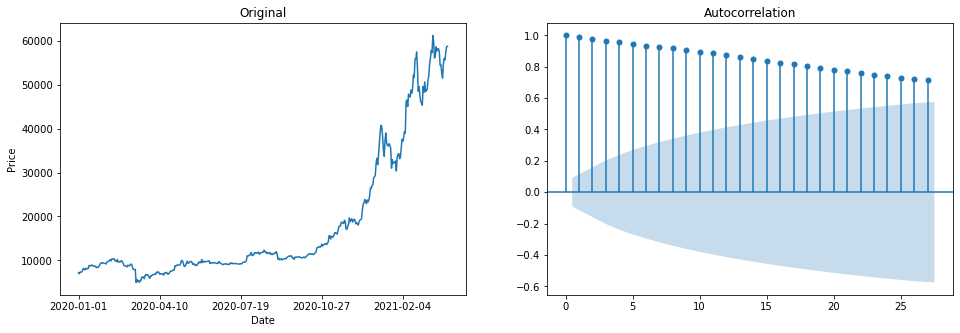

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
df_arima['Close'].plot(ax=ax1)
ax1.set_title('Original')
ax1.set_ylabel('Price')
plot_acf(df_arima['Close'], ax=ax2)
plt.savefig('../images/arima1.png', transparent=True)

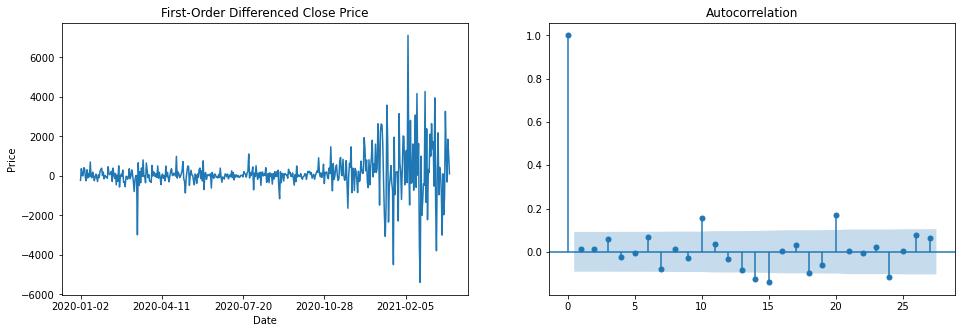

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
df_arima['Close'].diff().dropna().plot(ax=ax1)
ax1.set_title('First-Order Differenced Close Price')
ax1.set_ylabel('Price')
plot_acf(df_arima['Close'].diff().dropna(), ax=ax2)
plt.savefig('../images/arima2.png', transparent=True)

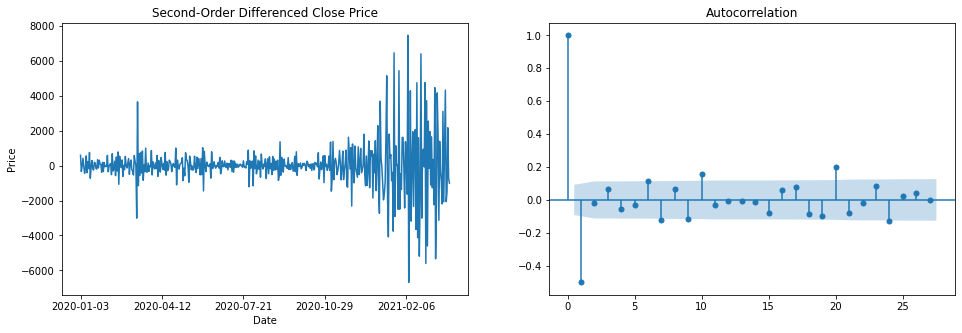

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
df_arima['Close'].diff().diff().dropna().plot(ax=ax1)
ax1.set_title('Second-Order Differenced Close Price')
ax1.set_ylabel('Price')
plot_acf(df_arima['Close'].diff().diff().dropna(), ax=ax2);
plt.savefig('../images/arima3.png', transparent=True)

We can see that taking the differenced `Close` cause our data to be independent. The first ACF plot shows clear correlations on each lagged values on each other. The second ACF plot shows that we managed to eliminate the correlation. The third ACF has a negative correlated for the first lagged value, possibly due to over differencing. We can conclude that the first difference is sufficient for our ARIMA model.

We also take a look at the partial autocorrelation (PACF) plot below.

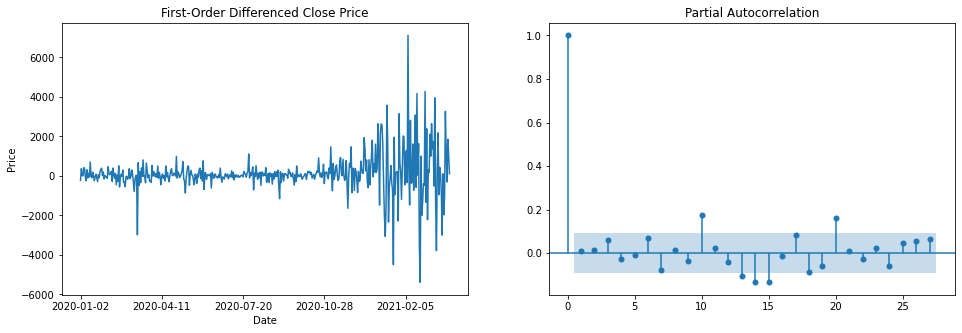

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
df_arima['Close'].diff().dropna().plot(ax=ax1)
ax1.set_title('First-Order Differenced Close Price')
ax1.set_ylabel('Price')
plot_pacf(df_arima['Close'].diff().dropna(), ax=ax2)
plt.savefig('../images/arima4.png', transparent=True)

We observe that the PACF at lag 10 and 20 are significant as they are above the significance line.

Split data to train (90%) and test (10%)

In [9]:
y_train, y_test = train_test_split(
    df_arima['Close'],
    test_size = 0.1,
    shuffle = False
)

Gridsearch to find optimal parameters

In [ ]:
# warnings.filterwarnings('ignore')

# best_aic = 9999999999999999999999
# best_p = 0
# best_q = 0

# for p in range(11):
#     for q in [5,10,15,20]:
#         try:
#             arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
#                           order = (p,1,q)) # values of p, d, q
#             model = arima.fit()
#             print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')
#             if model.aic < best_aic:
#                 best_aic = model.aic
#                 best_p = p
#                 best_q = q
#         except:
#             pass

# print(f'Best parameters to minimize AIC are:({best_p},1,{best_q}).')
# print(f'AIC: {best_aic}')

# warnings.filterwarnings('default')

The AIC for ARIMA(0,1,5) is: 6608.890542108632
The AIC for ARIMA(0,1,10) is: 6589.448791557271
The AIC for ARIMA(0,1,15) is: 6569.333779655799
The AIC for ARIMA(0,1,20) is: 6555.236562525754
The AIC for ARIMA(1,1,5) is: 6602.922386888962
The AIC for ARIMA(1,1,10) is: 6581.788960577198
The AIC for ARIMA(1,1,15) is: 6562.230353398481
The AIC for ARIMA(1,1,20) is: 6556.678281838323
The AIC for ARIMA(2,1,5) is: 6602.759330755374
The AIC for ARIMA(2,1,10) is: 6578.85726850086
The AIC for ARIMA(2,1,15) is: 6563.610787443536
The AIC for ARIMA(2,1,20) is: 6550.82042752841
The AIC for ARIMA(3,1,5) is: 6587.648567935312
The AIC for ARIMA(3,1,10) is: 6574.906049508447


Fit, predict and plot

In [ ]:
model_arima = ARIMA(endog = y_train,
              order = (10,1,10))

arima = model_arima.fit()

preds = model_arima.predict(params=arima.params,
                      start = y_test.index[0],
                      end = y_test.index[-1])

In [31]:
y_train.shape

(410,)

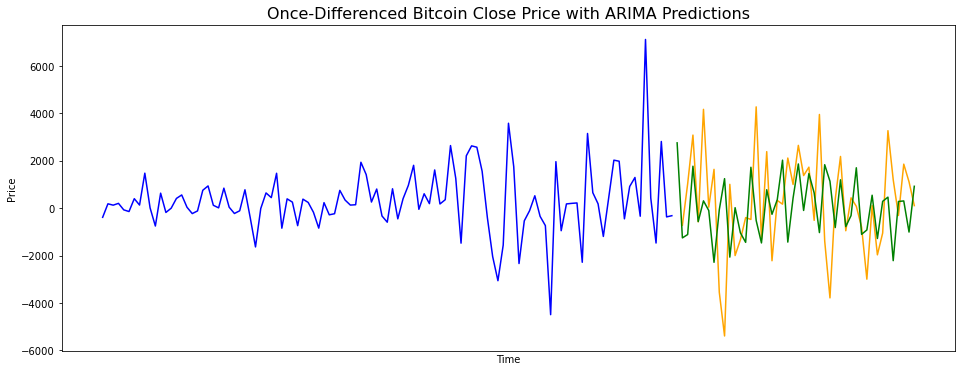

In [34]:
plt.figure(figsize=(16,6))
plt.plot(y_train.index[300:], pd.DataFrame(y_train[300:]).diff(), color = 'blue')
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Once-Differenced Bitcoin Close Price with ARIMA Predictions', fontsize=16)
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [11]:
arima.aic

6543.322092331597

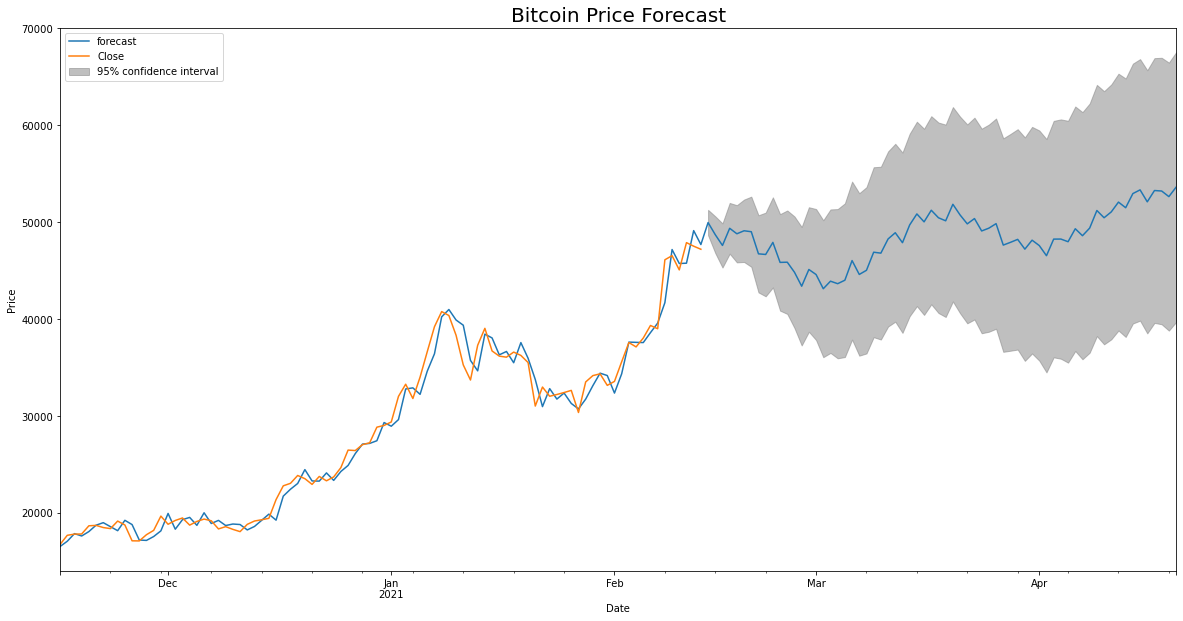

In [26]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
arima.plot_predict(
    start=320,
    end=475,
    dynamic=False,
    ax=ax,
)
plt.legend(loc=2)
plt.title('Bitcoin Price Forecast', size=20)
plt.ylabel('Price')
plt.xlabel('Date')
plt.savefig('../images/arima6.png', transparent=True)

ARIMA predicts Bitcoin to rise rather linearly which isin't very pragmatic as we've seen very large swings in price of Bitcoin. It does show that the general price of Bitcoin will increase over time.

## LSTM Price Prediction (Lookback = 1)

Here we use LSTM to do a price prediction with lookback=1. We'll only be using a univariate LSTM model with `LogClose`.

In [ ]:
features = [
    'LogClose',
]

btc = btc[features]

Fit and scale

In [ ]:
scaler = StandardScaler()
btc_scaled = scaler.fit_transform(btc)

X = btc_scaled
y = btc_scaled[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)

TimeseriesGenerator

In [ ]:
lookback = 1
batchsize = 32

In [ ]:
train_sequences = TimeseriesGenerator(X_train, y_train, length=lookback, batch_size=batchsize, sampling_rate=1)
test_sequences = TimeseriesGenerator(X_test, y_test, length=lookback, batch_size=batchsize, sampling_rate=1)

Our LSTM model consists of 2 LSTM layers and 2 Dense layers

In [ ]:
model1 = Sequential()
model1.add(LSTM(60, input_shape=(lookback,X_train.shape[1]), return_sequences=True, activation='relu'))
model1.add(LSTM(60))
model1.add(Dense(25, activation='relu'))
model1.add(Dense(1))

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 60)             14880     
_________________________________________________________________
lstm_5 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1525      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 45,471
Trainable params: 45,471
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop1 = EarlyStopping(monitor = 'val_loss', patience = 7, mode = 'auto')
model1.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

Fit and predict

In [ ]:
history1 = model1.fit_generator(
    train_sequences, 
    epochs=50, 
    validation_data=test_sequences, 
    shuffle=False,
    callbacks=[early_stop1]
)

Epoch 1/50
98/98 [==============================] - 4s 43ms/step - loss: 0.1134 - mean_absolute_error: 0.1137 - val_loss: 0.0923 - val_mean_absolute_error: 0.0904
Epoch 2/50
98/98 [==============================] - 1s 8ms/step - loss: 0.1084 - mean_absolute_error: 0.1087 - val_loss: 0.0827 - val_mean_absolute_error: 0.0808
Epoch 3/50
98/98 [==============================] - 1s 8ms/step - loss: 0.1049 - mean_absolute_error: 0.1052 - val_loss: 0.0819 - val_mean_absolute_error: 0.0801
Epoch 4/50
98/98 [==============================] - 1s 9ms/step - loss: 0.1036 - mean_absolute_error: 0.1039 - val_loss: 0.0767 - val_mean_absolute_error: 0.0749
Epoch 5/50
98/98 [==============================] - 1s 8ms/step - loss: 0.1008 - mean_absolute_error: 0.1011 - val_loss: 0.0747 - val_mean_absolute_error: 0.0730
Epoch 6/50
98/98 [==============================] - 1s 8ms/step - loss: 0.0981 - mean_absolute_error: 0.0984 - val_loss: 0.0750 - val_mean_absolute_error: 0.0734
Epoch 7/50
98/98 [=========

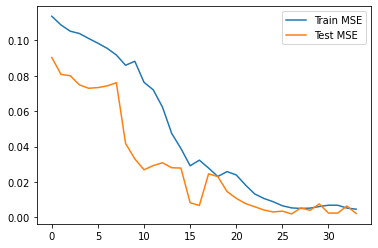

In [ ]:
plt.plot(history1.history['mean_absolute_error'], label='Train MSE')
plt.plot(history1.history['val_mean_absolute_error'], label='Test MSE')
plt.legend()
plt.savefig()

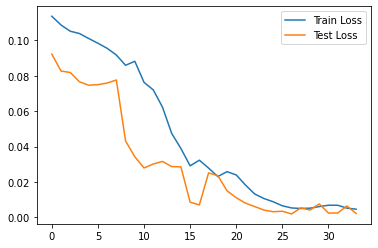

In [ ]:
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Test Loss')
plt.legend()

We see that loss and MSE curves decrease and converge at about epoch 27.

In [ ]:
model1.evaluate_generator(test_sequences)

[0.0021752764377743006, 0.0021459567]

In [ ]:
predictions = model1.predict_generator(test_sequences)

In [ ]:
X_test[:,1:][lookback:]

array([], shape=(781, 0), dtype=float64)

Plot the predictions

Text(0.5, 1.0, 'LSTM Price Prediction (1 Day Lookback)')

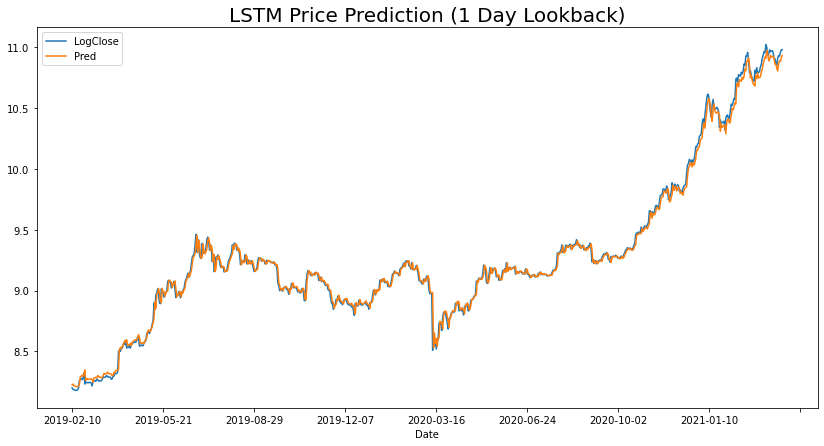

In [ ]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][lookback:])],axis=1)
df_pred = scaler.inverse_transform(df_pred)
df_pred_final = btc[predictions.shape[0]*-1:]
df_pred_final['Pred'] = df_pred[:,0]
df_pred_final['Pred_Diff'] = df_pred_final['LogClose'] - df_pred_final['Pred']
df_pred_final[['LogClose','Pred']].plot(figsize=(14,7))
plt.title('LSTM Price Prediction (1 Day Lookback)', size=20);

## LSTM Price Prediction (Lookback = 7)

We run an alternative model with a deeper lookback of 7 to see if there's any significant difference.

TimeseriesGenerator

In [ ]:
lookback = 7
batchsize = 32

train_sequences = TimeseriesGenerator(X_train, y_train, length=lookback, batch_size=batchsize, sampling_rate=1)
test_sequences = TimeseriesGenerator(X_test, y_test, length=lookback, batch_size=batchsize, sampling_rate=1)

LSTM Model

In [ ]:
model2 = Sequential()
model2.add(LSTM(60, input_shape=(lookback,X_train.shape[1]), return_sequences=True, activation='relu'))
model2.add(LSTM(60))
model2.add(Dense(25, activation='relu'))
model2.add(Dense(1))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 7, 60)             14880     
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1525      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 45,471
Trainable params: 45,471
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

Fit and predict

In [ ]:
history = model2.fit_generator(
    train_sequences, 
    epochs=50, 
    validation_data=test_sequences, 
    shuffle=False,
    callbacks=[early_stop]
)

Epoch 1/50
98/98 [==============================] - 6s 61ms/step - loss: 0.0308 - mean_absolute_error: 0.0309 - val_loss: 0.0349 - val_mean_absolute_error: 0.0335
Epoch 2/50
98/98 [==============================] - 3s 28ms/step - loss: 0.0307 - mean_absolute_error: 0.0309 - val_loss: 0.0407 - val_mean_absolute_error: 0.0395
Epoch 3/50
98/98 [==============================] - 3s 29ms/step - loss: 0.0229 - mean_absolute_error: 0.0230 - val_loss: 0.0408 - val_mean_absolute_error: 0.0397
Epoch 4/50
98/98 [==============================] - 2s 25ms/step - loss: 0.0207 - mean_absolute_error: 0.0208 - val_loss: 0.0255 - val_mean_absolute_error: 0.0246
Epoch 5/50
98/98 [==============================] - 3s 26ms/step - loss: 0.0148 - mean_absolute_error: 0.0149 - val_loss: 0.0155 - val_mean_absolute_error: 0.0150
Epoch 6/50
98/98 [==============================] - 3s 26ms/step - loss: 0.0132 - mean_absolute_error: 0.0132 - val_loss: 0.0392 - val_mean_absolute_error: 0.0382
Epoch 7/50
98/98 [====

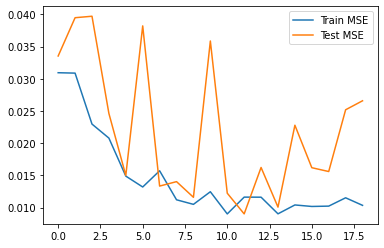

In [ ]:
plt.plot(history2.history['mean_absolute_error'], label='Train MSE')
plt.plot(history2.history['val_mean_absolute_error'], label='Test MSE')
plt.legend()

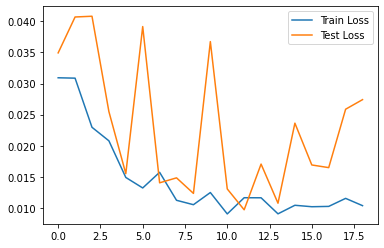

In [ ]:
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Test Loss')
plt.legend()

We see that our loss and MSE fluctuates way more than before, but generally on a decreasing trend.

In [ ]:
model2.evaluate_generator(test_sequences)

[0.027413691505789758, 0.026579203]

In [ ]:
predictions=model2.predict_generator(test_sequences)

In [ ]:
X_test[:,1:][lookback:]

array([], shape=(775, 0), dtype=float64)

Text(0.5, 1.0, 'LSTM Price Prediction (7 Days Lookback)')

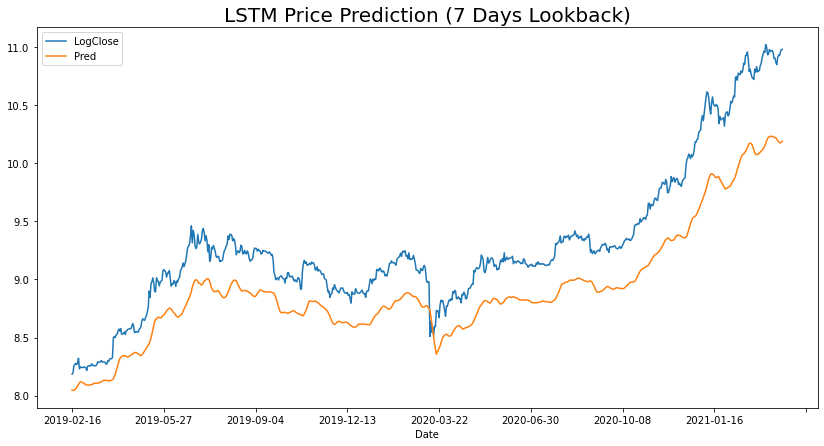

In [ ]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][lookback:])],axis=1)
df_pred = scaler.inverse_transform(df_pred)
df_pred_final = btc[predictions.shape[0]*-1:]
df_pred_final['Pred'] = df_pred[:,0]
df_pred_final['Pred_Diff'] = df_pred_final['LogClose'] - df_pred_final['Pred']
df_pred_final[['LogClose','Pred']].plot(figsize=(14,7))
plt.title('LSTM Price Prediction (7 Days Lookback)', size=20)

It's interesting to note that for some reason the increment in timesteps causes the forecase to "lag" with a gap. I realise that this is not a good way to do price prediction as the model is essentially predicting as close to the last close price as possible based on historical steps. The longer the time step, the more it adjusts downwards especially if price is on an increasing trend (the average of many ascending prices is going to be drastically lower for 7 time steps as compared to 1 time step).
  
It is then my conclusion that the many experiments that have attempted to use LSTM to do predictions on prices this way is misleading and inaccurate. Therefore, I've decided to do predictions on buy/sell signals instead.

# Buy/Sell Classifier Models

We control for features and parameters in this section below. Finalized features to be used after many iterations of modelling are below

    1. First order difference of logarithmic close price
    2. Logarithmic active address count
    3. Relative Strength Index

In [4]:
features = [
    'LogClose_Diff1',
    'LogAdrActCnt',
    'Target',
    'RSI'
]

lookback = 14
batchsize = 16

early_stop = EarlyStopping(monitor='val_acc', patience=15, verbose=0, mode='auto', restore_best_weights=True)

## RandomForest (Baseline)

Before conducting our LSTM models, we need to have a baseline measurement for performance. We'll use RandomForestClassifier here as our baseline.

Here we conduct a train-test split and scale with StandardScaler. I had decided not to use MinMax scaling contrary to common practice in this field because cryptocurrencies is on a exponential growth curve as shown in earlier EDA sections, and does not make sense to cap to a range of 0 to 1 based on historical prices as we expect the ceiling to increase even further. Note that we also use `Target_shifted` as we want to predict the next day's buy/sell signal.

In [5]:
features2 = [
    'LogClose_Diff1',
    'LogAdrActCnt',
    'RSI'
]

X = btc[features2]
y = btc['Target_shifted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [8]:
y_test.value_counts(normalize=True)

1    0.587179
0    0.412821
Name: Target_shifted, dtype: float64

In [9]:
y_train.value_counts(normalize=True)

1    0.53653
0    0.46347
Name: Target_shifted, dtype: float64

Gridsearch for best parameters

In [10]:
pipe_rf = Pipeline([('rf', RandomForestClassifier())])

pipe_rf_parms = {
    'rf__n_estimators': [10,50,100,200,300,400],
    'rf__max_depth': [2,3,4,5],
    'rf__min_samples_split': [2,3,4,5,6]
}

rf_gs = GridSearchCV(
    pipe_rf,
    param_grid=pipe_rf_parms,
    cv=5
)

rf_gs.fit(X_train, y_train)
rf_gs.best_score_

0.5496580395353575

In [11]:
rf_gs.best_params_

{'rf__max_depth': 5, 'rf__min_samples_split': 3, 'rf__n_estimators': 10}

In [12]:
rf_gs_best = rf_gs.best_estimator_
rf_gs_best.score(X_test, y_test)

0.5769230769230769

In [13]:
y_test.value_counts(normalize=True)

1    0.587179
0    0.412821
Name: Target_shifted, dtype: float64

In [14]:
rf_gs_best.predict(X_test)

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

We see that our RandomForestClassifier is not able to do well and classifies every prediction as a buy and in turn returning a score of 58.7% which is the same as our target variable's proportion.

## LSTM (Buy/Sell Signal)

Train-test split and scale. Note that I've decided to use StandardScaler instead of MinMaxScaler due to that Bitcoin price had always been increasing exponentially and it doesn't make sense to cap the price at current rates as we may see less generalization into future forecasting.

In [28]:
X = btc[features]
y = btc['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

TimeseriesGenerator

In [29]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=lookback, batch_size=batchsize)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=lookback, batch_size=batchsize)

In [30]:
model3 = Sequential()
model3.add(LSTM(50, input_shape=(lookback,X.shape[1]), return_sequences=True, activation='relu'))
model3.add(Dropout(0.3))
model3.add(LSTM(7, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 50)            11000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7)                 1624      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 12,632
Trainable params: 12,632
Non-trainable params: 0
_________________________________________________________________


Compile

In [31]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Fit and predict

In [ ]:
history3 = model3.fit_generator(
    train_sequences, 
    epochs=100, 
    validation_data=test_sequences, 
    shuffle=False, 
    callbacks=[early_stop]
)

Epoch 1/100
219/219 [==============================] - 13s 57ms/step - loss: 0.6869 - acc: 0.5476 - val_loss: 0.6831 - val_acc: 0.5878
Epoch 2/100
219/219 [==============================] - 9s 40ms/step - loss: 0.6861 - acc: 0.5496 - val_loss: 0.6816 - val_acc: 0.5931
Epoch 3/100
219/219 [==============================] - 10s 46ms/step - loss: 0.6843 - acc: 0.5479 - val_loss: 0.6813 - val_acc: 0.5904
Epoch 4/100
219/219 [==============================] - 11s 49ms/step - loss: 0.6836 - acc: 0.5487 - val_loss: 0.6817 - val_acc: 0.5904
Epoch 5/100
219/219 [==============================] - 7s 34ms/step - loss: 0.6837 - acc: 0.5599 - val_loss: 0.6814 - val_acc: 0.5904
Epoch 6/100
219/219 [==============================] - 7s 31ms/step - loss: 0.6834 - acc: 0.5585 - val_loss: 0.6812 - val_acc: 0.5851
Epoch 7/100
219/219 [==============================] - 7s 31ms/step - loss: 0.6818 - acc: 0.5585 - val_loss: 0.6811 - val_acc: 0.5984
Epoch 8/100
219/219 [==============================] - 9s 3

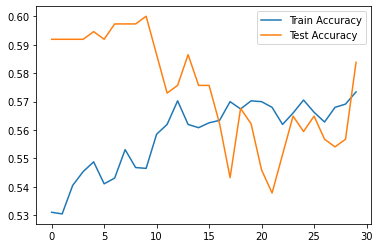

In [ ]:
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Test Accuracy')
plt.legend()

We observe 

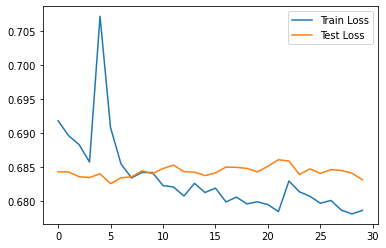

In [ ]:
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Test Loss')
plt.legend()

In [ ]:
preds_test = model4.predict(test_sequences)

In [ ]:
test_preds = preds_test[:, 0]

In [ ]:
y_test.values[14:]

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,

In [ ]:
actual_y = np.array(y_test.values[14:])
pred_y = np.array(test_preds)

preds = pd.DataFrame(actual_y, columns=['Y_Actual'])
preds['Y_Predicted'] = pred_y
preds['Y_Pred'] = np.where(preds['Y_Predicted'] > 0.5, 1, 0)
preds.drop(columns=['Y_Predicted'], inplace=True)

preds['Match'] = (preds['Y_Actual'] == preds['Y_Pred'])

In [ ]:
preds['Match'].value_counts(normalize=True)

True     0.6
False    0.4
Name: Match, dtype: float64

In [ ]:
preds

,Y_Actual,Y_Pred,Match
0,0,0,True
1,0,0,True
2,0,1,False
3,1,1,True
4,0,1,False
...,...,...,...
365,1,1,True
366,0,1,False
367,1,1,True
368,1,1,True


In [ ]:
test_preds > 0.5

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## LSTM (Buy/Sell Signal) with Leaky ReLU

After trying many different hyperparameters, I found that using Leaky Relu gave me the best accuracy result. Leaky Rectified Linear Unit, or Leaky ReLU, is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope.

In [3]:
model4 = load_model('model4.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
model4 = Sequential()
model4.add(LSTM(50, input_shape=(lookback,X.shape[1]), return_sequences=True))

model4.add(LeakyReLU(alpha=0.05))

model4.add(Dropout(0.3))

model4.add(LSTM(7))

model4.add(LeakyReLU(alpha=0.05))

model4.add(Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 14, 50)            11000     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 50)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 7)                 1624      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 12,632
Trainable params: 12,632
Non-trainable params: 0
__________________________________________________

Compile

In [10]:
model4.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Fit and predict

In [11]:
history4 = model4.fit_generator(
    train_sequences, 
    epochs=100, 
    validation_data=test_sequences, 
    shuffle=False, 
    callbacks=[early_stop]
)

Epoch 1/100
219/219 [==============================] - 10s 47ms/step - loss: 0.6872 - acc: 0.5433 - val_loss: 0.6845 - val_acc: 0.5745
Epoch 2/100
219/219 [==============================] - 6s 28ms/step - loss: 0.6853 - acc: 0.5504 - val_loss: 0.6844 - val_acc: 0.5585
Epoch 3/100
219/219 [==============================] - 7s 31ms/step - loss: 0.6843 - acc: 0.5553 - val_loss: 0.6863 - val_acc: 0.5346
Epoch 4/100
219/219 [==============================] - 10s 44ms/step - loss: 0.6847 - acc: 0.5461 - val_loss: 0.6850 - val_acc: 0.5452
Epoch 5/100
219/219 [==============================] - 7s 34ms/step - loss: 0.6836 - acc: 0.5484 - val_loss: 0.6809 - val_acc: 0.5771
Epoch 6/100
219/219 [==============================] - 7s 32ms/step - loss: 0.6832 - acc: 0.5533 - val_loss: 0.6850 - val_acc: 0.5346
Epoch 7/100
219/219 [==============================] - 8s 35ms/step - loss: 0.6820 - acc: 0.5610 - val_loss: 0.6861 - val_acc: 0.5346
Epoch 8/100
219/219 [==============================] - 16s 7

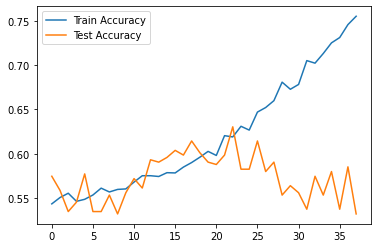

In [12]:
plt.plot(history4.history['acc'], label='Train Accuracy')
plt.plot(history4.history['val_acc'], label='Test Accuracy')
plt.legend()

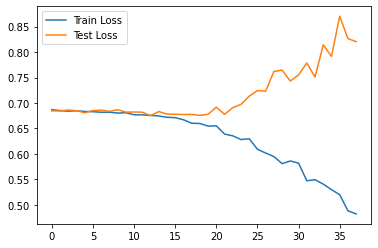

In [13]:
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Test Loss')
plt.legend()

We see that test loss decreases slightly at the start but increases drastically after 20 epochs. We also observe that the best score at epoch 19 gave a train accuracy of 58% and test accuracy of 62%, surpasing our base target by 4%.

In [15]:
preds_test = model4.predict(test_sequences)

In [16]:
test_preds = preds_test[:, 0]

In [17]:
actual_y = np.array(y_test.values[14:])
pred_y = np.array(test_preds)

preds = pd.DataFrame(actual_y, columns=['Y_Actual'])
preds['Y_Predicted'] = pred_y
preds['Y_Pred'] = np.where(preds['Y_Predicted'] > 0.5, 1, 0)
preds.drop(columns=['Y_Predicted'], inplace=True)

preds['Match'] = (preds['Y_Actual'] == preds['Y_Pred'])

In [18]:
preds['Match'].value_counts(normalize=True)

True     0.630319
False    0.369681
Name: Match, dtype: float64

In [19]:
preds

,Y_Actual,Y_Pred,Match
0,1,1,True
1,0,1,False
2,1,1,True
3,1,1,True
4,0,0,True
...,...,...,...
371,1,1,True
372,0,0,True
373,1,1,True
374,1,1,True


In [20]:
test_preds > 0.5

array([ True,  True,  True,  True, False, False, False,  True,  True,
        True, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True,  True,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
       False, False,  True,  True,  True, False, False,  True,  True,
       False, False,  True, False,  True, False, False,  True, False,
        True, False,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True, False, False,
       False,  True, False, False, False, False, False,  True, False,
        True,  True, False,  True,  True,  True, False, False, False,
        True,  True,

In [21]:
model4.save('model4.h5')

# Analysis

Let's take a look at how much our returns will be if we implement our best model (LSTM with Leaky Relu) into production. We first patch our test predictions to the main data.

In [22]:
X_test_preds = X_test.join(btc[['Close', 'Returns']], how='left')
X_test_preds = X_test_preds[14:]
X_test_preds.reset_index(inplace=True)
X_test_preds = pd.concat([X_test_preds, preds], axis=1)
X_test_preds

,Date,LogClose_Diff1,LogAdrActCnt,Target,RSI,Close,Returns,Y_Actual,Y_Pred,Match
0,2020-03-21,0.000272,13.365394,1,39.258464,6175.831022,0.000272,1,1,True
1,2020-03-22,-0.057530,13.270613,0,36.532464,5830.560980,-0.055907,0,1,False
2,2020-03-23,0.106596,13.411274,1,44.426341,6486.408657,0.112484,1,1,True
3,2020-03-24,0.043539,13.509302,1,47.520079,6775.057619,0.044501,1,1,True
4,2020-03-25,-0.012639,13.283563,0,46.694859,6689.969013,-0.012559,0,0,True
...,...,...,...,...,...,...,...,...,...,...
371,2021-03-27,0.021690,13.954753,1,54.812868,56019.837306,0.021927,1,1,True
372,2021-03-28,-0.005492,13.877050,0,54.009377,55713.038140,-0.005477,0,0,True
373,2021-03-29,0.032809,13.924836,1,58.022960,57571.233348,0.033353,1,1,True
374,2021-03-30,0.019153,13.959075,1,60.260627,58684.548392,0.019338,1,1,True


Convert `Date` to datetime format and set as index

In [23]:
X_test_preds['Date'] = pd.to_datetime(X_test_preds['Date'] )
X_test_preds.set_index('Date', inplace=True)

Generate a `Returns_Pct` column for easier calculation of cumulative returns.

In [24]:
X_test_preds['Returns_Pct'] = 1 + X_test_preds['Returns']

Let's take a look at how much one can earn if one holds BTC throughout this period. We can obtain that by doing a cumulative product of `Returns_Pct`

In [25]:
X_test_preds['Returns_Pct'].cumprod().tail(1).values

array([9.52231478])

We see that we'll generate **952%** in returns over this time period. This is the target we want to beat if we were to implement our trading prediction model.

In [26]:
X_test_preds[X_test_preds['Y_Actual'] == 1]['Returns_Pct'].cumprod().tail(1).values

array([353.55626778])

**35300%** returns if one is able to predict perfectly the market

In [27]:
X_test_preds[X_test_preds['Y_Pred'] == 1]['Returns_Pct'].cumprod().tail(1).values

array([8.86747172])

Our model generates a **886%** return, and does not beat a buy-and-hold strategy. We can see that though our accuracy was 5% higher than the dominant target variable porportion, we were actually missing on on potential gains and perhaps chalking up more losses from wrong predictions as compared to simply just buying and holding. In order to have a production model we probably need a model with higher accuracy to reduce situations described above. The old mantra of "hodling" perhaps may be the best strategy to apply here.

# Conclusion

This project yielded several interesting observations after attempting different methods of predicting and forecasting price of Bitcoin. Here's some takeaway from our EDA section:

**Bitcoin adoption is growing exponentially**  
Let's be clear here, logarithmic scales show relative values instead of absolute, so if we see a consistently uptrend on our logarithmic charts, it's clear that things are growing exponentially. This is also true for Bitcoin price which goes up as adoption goes up. The growth in active unique addresses trends upward on the log scale, and perhaps some of Meltcalfe's Law plays true here. (Metcalfe's law states that the value of a network is proportional to the square of the number of connected users of the system).

**What goes up must come down (but how much?)**
We see huge spikes in Bitcoin price over the years, and clearly the earlier time period volatility have been masked by the later price swings in the later years. However, we also observe that Bitcoin price have almost never crossed the SMA1458 line (the 4 year moving average). This signifies to us that though we can expect market corrections and pullbacks, we can take comfort that the lowest point is likely not going to be that of previous years. Whether it makes sense to buy now at a high price (relative to previous prices) or wait for a market correction to enter is something the reader would need to make an individual decision on if he/she decides to enter the market.\

Here are some takeaways from our modelling section:
  
**LSTM's performance**
This is a tough one to call, as one can decide that a 4% edge over the market is decent enough to build a trading strategy on. It did indeed gave 70% more returns as compared to simply buying and holding for the same timeframe. Additionally, I've tried to no avail various measures to tune for better performance, whether its on deepening the model, feeding different features, changing hyperparameters. It also seems that LSTM is rather inconsistent in providing results as we can see rather big differences in scores when the model is run everything single time. Given that we're taking on a real life financial challenge here, it is not advisable to simply lift this code and implement for own trading purposes. Please exercise and do your own research.

**Sometimes lesser is better**  
I had tried feeding several features into the model but I find that as I fed more features in, the model became more unpredictable and it was harder for much transfer learning to happen. Efficient market hypothesis in some sense plays a part - alot of the movement in prices are noise and perhaps that's why my nueral network is not able to do much transfer learning in that sense.